# AI Launch Lab - Sea Ice Movement Challenge - Training

Do some more analysis on the data before choosing our final model.

In [2]:
import pandas as pd
import pickle
import os 
pd.options.mode.chained_assignment = None
import datetime
import numpy as np
import os
import zipfile
import modules.ml_pipeline.readdata as mlpp
import sys

Load the data from disk and display it

In [3]:
# unzip the zip dataset
with zipfile.ZipFile('data/converted_full.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

# Load the raw data to disk
input_path = "data/converted.csv"
df = pd.read_csv(input_path)

# Convert all column names to lower case and display the dataframe 
df = df.rename(str.lower, axis='columns')

In [4]:
# Do some manipulations on the data and clean it (remove rows of all NaNs, remove duplicates, etc.)

# Remove any rows that have buoy velocity/mag =0 
df = df.drop(df[df["buoy_vel_mag"] == 0].index)

# Remove any rows that have very low ice_thickness  
"""
sea ice concentration of 0.5 means that the surroundings of the buoy is 50% sea ice and 50% open water. So ice concentration of 
1 is full ice cover, while a concentration of 0.1 means there’S barely any ice left at that location!
"""
df = df.drop(df[df["ice_thickness"] < 0.1].index)

# Print the dataframe dimensions
print("Dataframe final shape: ", df.shape)
display(df)

Dataframe final shape:  (327042, 21)


,index,year,month,day,doy,x_ease,y_ease,u_buoy,v_buoy,id_buoy,...,v_era5,sic_cdr,d2c,ice_thickness,buoy_lat,buoy_lon,buoy_vel_mag,buoy_vel_dir,wind_vel_mag,wind_vel_dir
0,0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,...,-0.321260,0.990195,522.523298,3.189743,78.007070,-128.549129,1.370671,2.191824,6.711849,3.189490
1,1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,...,-0.674205,0.966372,412.767669,2.484009,74.498024,-119.750294,0.741408,0.520564,6.851881,3.240164
2,2,1979,2,18,49,130.993561,129.623672,-1.162420,0.243717,1914,...,1.123955,0.996022,362.547379,2.474106,74.003619,-134.786524,1.187695,2.934923,8.896751,3.014921
3,3,1979,2,18,49,147.524719,157.382492,0.919766,0.025784,1918,...,-1.035410,0.982681,381.025629,3.740522,81.019593,-145.578020,0.920127,0.028026,1.496117,3.905953
4,4,1979,2,19,50,147.470963,138.599823,0.380940,1.243485,1906,...,2.537787,0.990302,521.535334,3.188522,78.002077,-128.560665,1.300527,1.273525,3.338513,2.278041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329883,339472,2019,12,30,364,173.589722,117.012932,-13.455300,-10.662800,25560,...,-4.199740,1.000000,470.197315,0.933125,75.686986,-96.341501,17.168005,3.811734,8.234026,3.676847
329884,339473,2019,12,30,364,193.232056,172.742004,-0.981225,-11.698400,44880,...,-6.012877,1.000000,702.312813,1.517084,86.513431,-29.153877,11.739478,4.628723,6.522125,4.314615
329885,339474,2019,12,30,364,208.421234,142.049896,-7.247925,-5.289890,53005,...,-0.381765,1.000000,360.491321,1.164462,79.286760,-53.579091,8.973035,3.772087,4.630856,3.224141
329886,339475,2019,12,30,364,145.264023,146.109741,-0.913761,2.182150,95020,...,1.119087,1.000000,393.799208,2.010032,79.025667,-135.924079,2.365742,1.967356,2.240471,0.523007


Define the train/test variables that we will use. 

In [5]:
print("Sea Ice Movement Datasets")
training_targets = df[["buoy_vel_mag","buoy_vel_dir"]]

# We will leave the month for now because it could be an indicator of weather/season 
print("Target Variables")
display(training_targets)

Sea Ice Movement Datasets
Target Variables


,buoy_vel_mag,buoy_vel_dir
0,1.370671,2.191824
1,0.741408,0.520564
2,1.187695,2.934923
3,0.920127,0.028026
4,1.300527,1.273525
...,...,...
329883,17.168005,3.811734
329884,11.739478,4.628723
329885,8.973035,3.772087
329886,2.365742,1.967356


In [73]:
# Drop the time related columns 
training_data = df.drop(["index", "month", "year","day","sic_cdr", "doy", "id_buoy", "x_ease", "y_ease", "buoy_lon","buoy_lat", "u_buoy", "v_buoy","buoy_vel_mag","buoy_vel_dir"], axis = 1)
display(training_data)

,u_era5,v_era5,d2c,ice_thickness,wind_vel_mag,wind_vel_dir
0,-6.704156,-0.321260,522.523298,3.189743,6.711849,3.189490
1,-6.818630,-0.674205,412.767669,2.484009,6.851881,3.240164
2,-8.825469,1.123955,362.547379,2.474106,8.896751,3.014921
3,-1.079951,-1.035410,381.025629,3.740522,1.496117,3.905953
4,-2.169171,2.537787,521.535334,3.188522,3.338513,2.278041
...,...,...,...,...,...,...
329883,-7.082469,-4.199740,470.197315,0.933125,8.234026,3.676847
329884,-2.526544,-6.012877,702.312813,1.517084,6.522125,4.314615
329885,-4.615093,-0.381765,360.491321,1.164462,4.630856,3.224141
329886,1.940967,1.119087,393.799208,2.010032,2.240471,0.523007


In [74]:
# Evaluate multioutput regression models
%matplotlib inline
import numpy as np
import time 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

Split the dataset into training and validation sets. 

In [75]:
# test_size: what proportion of original data is used for test set
train_data, test_data, train_labels, test_labels = train_test_split(
    training_data, training_targets, test_size= 0.25, shuffle=False)

# show the sizes of the training and test sets
print("Training data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

print("Training labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Training data shape:  (245281, 6)
Test data shape:  (81761, 6)
Training labels shape:  (245281, 2)
Test labels shape:  (81761, 2)


Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data

In [76]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()

# Fit on training set only.
scaler.fit(train_data)

# Apply transform to both the training set and the test set.
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# display the normalized data
display(train_data)

array([[0.39803497, 0.46096341, 0.46621567, 0.49957573, 0.27587577,
        0.50762548],
       [0.39523341, 0.45275704, 0.36822009, 0.38546428, 0.2816406 ,
        0.51569054],
       [0.34611969, 0.49456622, 0.32338078, 0.38386313, 0.36582357,
        0.47984164],
       ...,
       [0.83041039, 0.24937731, 0.0121849 , 0.34582317, 0.59465206,
        0.88702397],
       [0.79226026, 0.24921579, 0.01772392, 0.34746905, 0.5477813 ,
        0.87480607],
       [0.83041039, 0.24937731, 0.01341009, 0.34582317, 0.59465206,
        0.88702397]])

Create a series of models and calculate the predictions.

In [79]:
# K-NEAREST NEIGHBOR MODEL 

# create model
regr_KNN = KNeighborsRegressor(n_neighbors=7)

# train the model 
print("Training KNN Regressor...")
start = time.time()
regr_KNN.fit(train_data, train_labels)
end = time.time()
print("Model training time: ", end-start)

# Calculate the new predictions and print the regression score:
print("Predicting scores...")
y_KNN=regr_KNN.predict(test_data)
print("Regression Score: ", regr_KNN.score(test_data, test_labels))

Training KNN Regressor...
Model training time:  0.3255958557128906
Predicting scores...
Regression Score:  0.4245326678642652


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [70]:
# K-NEAREST NEIGHBOR MODEL 

# create model
regr_KNN_vel = KNeighborsRegressor(n_neighbors=7)

# train the model 
print("Training KNN Regressor...")
start = time.time()
regr_KNN_vel.fit(train_data, train_labels["buoy_vel_mag"])
end = time.time()
print("Model training time: ", end-start)

# Calculate the new predictions and print the regression score:
print("Predicting scores...")
y_KNN=regr_KNN_vel.predict(test_data)
print("Regression Score: ", regr_KNN_vel.score(test_data, test_labels["buoy_vel_mag"]))

Training KNN Regressor...
Model training time:  0.2690010070800781
Predicting scores...
Regression Score:  0.4258863050613091


In [71]:
# K-NEAREST NEIGHBOR MODEL 

# create model
regr_KNN_dir = KNeighborsRegressor(n_neighbors=7)

# train the model 
print("Training KNN Regressor...")
start = time.time()
regr_KNN_dir.fit(train_data, train_labels["buoy_vel_dir"])
end = time.time()
print("Model training time: ", end-start)

# Calculate the new predictions and print the regression score:
print("Predicting scores...")
y_KNN=regr_KNN_dir.predict(test_data)
print("Regression Score: ", regr_KNN_dir.score(test_data, test_labels["buoy_vel_dir"]))

Training KNN Regressor...
Model training time:  0.2718167304992676
Predicting scores...
Regression Score:  0.3420644566406815


In [63]:
# LINEAR REGRESSION MODEL 

# create model
regr_LR = LinearRegression()

# train the model 
print("Training Linear Regressor...")
start = time.time()
regr_LR.fit(train_data, train_labels)
end = time.time()
print("Model training time: ", end-start)

# Calculate the new predictions and print the regression score:
print("Predicting scores...")
y_LR = regr_LR.predict(test_data)
print("Regression Score: ", regr_LR.score(test_data,test_labels))

Training Linear Regressor...
Model training time:  0.03417515754699707
Predicting scores...
Regression Score:  0.41797354417378396


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [64]:
# DECISION TREE MODEL 

# create model
regr_DT = DecisionTreeRegressor()

# train the model 
print("Training Decision Tree Regressor...")
start = time.time()
regr_DT.fit(train_data, train_labels)
end = time.time()
print("Model training time: ", end-start)

# Calculate the new predictions and print the regression score:
print("Predicting scores...")
y_DT = regr_DT.predict(test_data)
print("Regression Score: ", regr_DT.score(test_data,test_labels))

Training Decision Tree Regressor...
Model training time:  3.75419282913208
Predicting scores...
Regression Score:  0.007615252623098749


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [43]:
# RANDOM FOREST  MODEL 

# create model
regr_rf = RandomForestRegressor(n_estimators=50)

# train the model 
print("Training Random Forest Regressor...")
start = time.time()
regr_rf.fit(train_data, train_labels)
end = time.time()
print("Model training time: ", end-start)

# Calculate the new predictions and print the regression score:
print("Predicting scores...")
y_RF = regr_rf.predict(test_data)
print("Regression Score: ", regr_rf.score(test_data, test_labels))

Training Random Forest Regressor...
Model training time:  81.92626357078552
Predicting scores...
Regression Score:  0.470768993964505


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [ ]:
""""This one is kinda long to run... Commenting for now. """

"""
# MULTIOUPUT REGRESSOR MODEL

# create model
regr_multirf = MultiOutputRegressor(RandomForestRegressor())

# train the model 
print("Training Random Forest Multioutput Regressor...")
start = time.time()
regr_multirf.fit(train_data, train_labels)
end = time.time()
print("Model training time: ", end-start)

# Calculate the new predictions and print the regression score:
print("Predicting scores...")
y_multirf = regr_multirf.predict(test_data)
print("Regression Score: ", regr_rf.score(test_data,test_labels))
"""

In [ ]:
"""
# SUPPORT VECTOR REGRESSOR MODEL

#This one is kinda long to run... Commenting for now.

# create model
regr_svm = MultiOutputRegressor(LinearSVR())

# train the model 
print("Training SVM Regressor...")
start = time.time()
regr_svm.fit(train_data, train_labels)
end = time.time()
print("Model training time: ", end-start)

# Calculate the new predictions and print the regression score:
print("Predicting scores...")
y_svm = regr_svm.predict(test_data)
print("Regression Score: ", regr_svm.score(test_data, test_labels))
"""

# Scoring and Visualizing the Results 

Here, we take a look at the regression results for each model and compare them. Using this, we can select the most performant one and try and reduce overfitting even more in the next step. 


In [80]:
#model_names = ["K-Nearest-Neighbor", "Linear Regression", "Decision Trees", "Random Forests", "MultiOutput Random Forests", "SVM"]
model_names = ["K-Nearest-Neighbor", "Linear Regression", "Decision Trees", "Random Forests"]

#predictions = [y_KNN, y_LR, y_DT, y_rf, y_multiRF, ysvm]
predictions = [y_KNN]

# create our custom scoring function
from sklearn.metrics import mean_squared_error 

def sea_ice_score(y_pred, y_true):  
    # convert the predictions array to a dataframe 
    y_pred = pd.DataFrame(data=y_pred, columns=y_true.columns)
    
    # calculate the root mean squared error between the two variables 
    rmse = mean_squared_error(y_true, y_pred)
    return y_pred, rmse 

Overall RMSE:  21.058419383996217


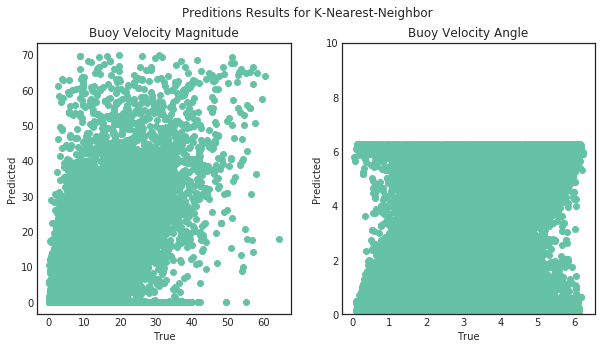

In [82]:
# Plot results for KNN 
y_KNN, rmse = sea_ice_score(y_KNN, test_labels)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
fig.suptitle('Preditions Results for ' + model_names[0])

ax1.scatter(y_KNN["buoy_vel_mag"], test_labels["buoy_vel_mag"])
ax1.set_ylabel("Predicted")
ax1.set_xlabel("True")
ax1.set_title('Buoy Velocity Magnitude')

ax2.scatter(y_KNN["buoy_vel_dir"], test_labels["buoy_vel_dir"])
ax2.set_ylabel("Predicted")
ax2.set_xlabel("True")
ax2.set_ylim(0, 10)
ax2.set_title('Buoy Velocity Angle')

print("Overall RMSE: ", rmse)

In [ ]:
# Plot results for Linear Regression
y_LR, rmse = sea_ice_score(y_LR, test_labels)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
fig.suptitle('Preditions Results for ' + model_names[1])

ax1.scatter(y_LR["buoy_vel_mag"], test_labels["buoy_vel_mag"])
ax1.set_ylabel("Predicted")
ax1.set_xlabel("True")
ax1.set_title('Buoy Velocity Magnitude')

ax2.scatter(y_LR["buoy_vel_dir"], test_labels["buoy_vel_dir"])
ax2.set_ylabel("Predicted")
ax2.set_xlabel("True")
ax2.set_ylim(0, 10)
ax2.set_title('Buoy Velocity Angle')

print("Overall RMSE: ", rmse)

In [ ]:
# Plot results for Decision Trees
y_DT, rmse = sea_ice_score(y_DT, test_labels)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
fig.suptitle('Preditions Results for ' + model_names[2])

ax1.scatter(y_DT["buoy_vel_mag"], test_labels["buoy_vel_mag"])
ax1.set_ylabel("Predicted")
ax1.set_xlabel("True")
ax1.set_title('Buoy Velocity Magnitude')

ax2.scatter(y_DT["buoy_vel_dir"], test_labels["buoy_vel_dir"])
ax2.set_ylabel("Predicted")
ax2.set_xlabel("True")
ax2.set_xlim(0, 7.5)
ax2.set_ylim(0, 7.5)
ax2.set_title('Buoy Velocity Angle')

print("Overall RMSE: ", rmse)

In [ ]:
# Plot results for Random Forests 
y_RF, rmse = sea_ice_score(y_DT, test_labels)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
fig.suptitle('Preditions Results for ' + model_names[3])

ax1.scatter(y_RF["buoy_vel_mag"], test_labels["buoy_vel_mag"])
ax1.set_ylabel("Predicted")
ax1.set_xlabel("True")
ax1.set_title('Buoy Velocity Magnitude')

ax2.scatter(y_RF["buoy_vel_dir"], test_labels["buoy_vel_dir"])
ax2.set_ylabel("Predicted")
ax2.set_xlabel("True")
ax2.set_ylim(0, 10)
ax2.set_title('Buoy Velocity Angle')

print("Overall RMSE: ", rmse)

# Saving the model

Models will be scored based on the metrics provided in the challenge description. That is the difference between the predicted estimate values and the actual true values. 

In [ ]:
# create our custom scoring function
from sklearn.metrics import mean_squared_error 

def sea_ice_score(y_true, y_pred):  
    y_pred = pd.DataFrame(data=y_pred, columns=y_true.columns)
    rmse = mean_squared_error(y_true, y_pred)
    return y_true, rmse 